In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Training Efficiency Comparison

## VGG7-64 on Cifar100
The data format is list of different methods.
For the DNS results, we have most 5 rows for dns_ratio=[0.1,0.3,0.5,0.7,0.9]    

In [2]:
head = ["Batch Size","w DNS", "DNS-ratio", "w FR", "Forward","Backward","Data","Other"] 
dsn_values = [[500,	0, 0, 0,	1.251,	1.7564,	0.0067,	0.0097],
              []
              ]

In [11]:
import os
log_root= f"./scripts/logs"
log_names = ["vgg7_64_cifar100-mtl-training-efficiency-evaluation-v1-dns_ratio-0.5-evaluate-training-efficiency.log"]
log_files = [f"{log_root}/{log_name}" for log_name in log_names]

heads = ['use_dns',
  'dns_ratio',
  'use_fr',
  'useKD',
  'useFD',
  'Iteartion',
  'Forward time',
  'Backward time',
  'Data time',
  'Other time',
  'Total time',
  'FPS',
  'BatchSize',
  'GPU']
# 使用use_dns，dns_ratio，use_fr，useKD，useFD作为筛选条件,-1表示不筛选
filter_keys = ['use_dns',
        'dns_ratio',
        'use_fr',
        'useKD',
        'useFD']
dsn_filters = [0,-1,0,0,0]
dns_filters =    [1,-1,1,0,0]
msdnet_filters = [0,-1,0,1,0]
byot_filters =   [0,-1,0,1,1]

need_keys = ['dns_ratio','Forward time',
  'Backward time',
  'Data time',
  'Other time',
  'Total time',
  'FPS',
  'BatchSize']

def filter_results(results, filter, need_keys):
    res = []
    for model_name, values in results.items():
        need_this = True
        for k,v in zip(filter_keys,filter):
            if v != -1 and values[k] != v:
                need_this = False
                break
        if need_this:
            res.append([values[key] if key in values.keys() else None for key in need_keys])
    return res

def get_res_from_logfile(log_file,heads, filters, filter_keys, need_keys,start_line=0):
    logs_lines = []
    if not os.path.exists(log_file):
        print(f"file {log_file} not exists")
    # 读取日志文件
    with open(log_file, 'r') as f:
        logs_lines = f.readlines()[start_line:]

    # 定义正则表达式
    pattern = r"##[\t ]*([\w ]+):[\t ]*([\w\.\- ]+)"
    model_name_pattern = r"use_dns-(\d)-([\d\.]+)-use_fr-(\d)-useKD-(\d)-useFD-(\d)"
    results = {}
    line = []
    model_name = None
    # 从日志文件中提取数据
    for line in logs_lines:
        res = re.findall(pattern, line)
        if res is None:
            continue
        res_dict = dict(res)
        if "Model" in res_dict:
            # 开启新的一行
            model_name = res_dict["Model"]
            continue
        elif "BatchSize" in res_dict and model_name is not None:
            model_name += f"-batchsize-{int(res_dict['BatchSize'])}"
            if model_name not in results.keys():
                results[model_name] = {}
                model_name_pattern_res = re.findall(model_name_pattern, model_name)
                # print("model_name", model_name)
                # print("model_name_pattern_res", model_name_pattern_res)
                if model_name_pattern_res:
                    use_dns, dns_ratio, use_fr, useKD, useFD = model_name_pattern_res[0]
                    results[model_name]["use_dns"] = int(use_dns)
                    results[model_name]["dns_ratio"] = float(dns_ratio)
                    results[model_name]["use_fr"] = int(use_fr) if int(use_dns) else 0
                    results[model_name]["useKD"] = int(useKD)
                    results[model_name]["useFD"] = int(useFD)
                    results[model_name]["BatchSize"] = int(res_dict['BatchSize'])
                    
            else:
                # print(f"{model_name} has already been in results, update to new one")
                pass
        elif model_name is not None and model_name in results.keys():
            # 添加新的一列
            # print(model_name)
            for k,v in res_dict.items():
                results[model_name][k]=v 
        else:
            continue
    # print(results)
    # format results
    for model_name, values in results.items():
        new_values = {}
        for head_name in heads:
            if head_name in values.keys():
                v = values[head_name]
                if isinstance(v, str):
                    v = v.split(" ")[0]
                    if v.isdigit():
                        v = int(v)
                    elif v.replace('.','',1).isdigit():
                        v = float(v)
                    elif head_name == "GPU":
                        # print(f"head_name: {head_name} is not digit, value is {v}")
                        v = None
                new_values[head_name] = v
        results[model_name] = new_values
    # filter the needed results
    result_list = filter_results(results, filters, need_keys)

    return results, result_list
def process_results_to_abs_cap_by_ratio_batchsize(results,dns_ratios=[0.5],batchsizes=[128,192,256]):
       # dsn_results
    batchsize_id = -1
    dns_ratio_id = 0
    # len_bs = len(batchsizes)
    results = [line for line in results if line[dns_ratio_id] in dns_ratios and line[batchsize_id] in batchsizes]
    len_res = len(results)
    # 必须按照batchsize排序
    results = sorted(results, key=lambda x:x[batchsize_id])
    results = np.array(results)
    res_abs = results[:,1:5].sum(axis=1)
    res_cap = results[:,1:5]/res_abs.reshape(len_res,-1)
    # 最后两列相加
    res_cap = np.concatenate([res_cap[:,:2],res_cap[:,2:].sum(1).reshape(len_res,-1)],axis=1)
    return res_abs, res_cap
# process_results_to_abs_cap_by_ratio_batchsize

In [12]:
# 获取数据
log_root = f"./scripts/logs"
# log_names = [f"vgg7_64_cifar100-mtl-training-efficiency-evaluation-v1-dns_ratio-{i:.1f}-evaluate-training-efficiency.log" for i in [0.1,0.3,0.5,0.7,0.9]] # first exepriment
log_names = [f"vgg7_64_cifar100-mtl-training-efficiency-evaluation-v3-dns_ratio-{i:.1f}-evaluate-training-efficiency.log" for i in [0.1,0.3,0.5,0.7,0.9]] # second exepriment

log_files = [f"{log_root}/{log_name}" for log_name in log_names]

# save to csv files
save_dir = f"./data-src"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
dsn_save_file = f"{save_dir}/vgg7_64_cifar100-mtl-training-efficiency-dsn-v3.csv"
dns_save_file = f"{save_dir}/vgg7_64_cifar100-mtl-training-efficiency-dns-v3.csv"
msdnet_save_file = f"{save_dir}/vgg7_64_cifar100-mtl-training-efficiency-msdnet-v3.csv"
byot_save_file = f"{save_dir}/vgg7_64_cifar100-mtl-training-efficiency-byot-v3.csv"

dsn_results = []
dns_results = []
msdnet_results = []
byot_results = []

read_from_log =False

if read_from_log or not os.path.exists(dsn_save_file):
    # 从日志文件中提取数据并存储到csv文件中
    for log_file in log_files:
        _,dsn_res = get_res_from_logfile(log_file,heads, dsn_filters, filter_keys, need_keys,0)
        _,dns_res = get_res_from_logfile(log_file,heads, dns_filters, filter_keys, need_keys,0)
        _,msdnet_res = get_res_from_logfile(log_file,heads, msdnet_filters, filter_keys, need_keys,0)
        _,byot_res = get_res_from_logfile(log_file,heads, byot_filters, filter_keys, need_keys,0)
        dsn_results+=dsn_res
        dns_results+=dns_res
        msdnet_results+=msdnet_res
        byot_results+=byot_res
    # _,res = get_res_from_logfile(log_files[0],heads, dsn_filters, filter_keys, need_keys,0)
    # save to file
    import pandas as pd
    pd.DataFrame(dsn_results, columns=need_keys).to_csv(dsn_save_file, index=False)
    pd.DataFrame(dns_results, columns=need_keys).to_csv(dns_save_file, index=False)
    pd.DataFrame(msdnet_results, columns=need_keys).to_csv(msdnet_save_file, index=False)
    pd.DataFrame(byot_results, columns=need_keys).to_csv(byot_save_file, index=False)
else:
    # 从csv文件中读取数据
    import pandas as pd
    dsn_results = pd.read_csv(dsn_save_file).values.tolist()
    dns_results = pd.read_csv(dns_save_file).values.tolist()
    msdnet_results = pd.read_csv(msdnet_save_file).values.tolist()
    byot_results = pd.read_csv(byot_save_file).values.tolist()

In [13]:
dsn_results,dns_results

([[0.5, 0.2513, 0.3146, 0.0028, 0.0047, 0.5734, 523.1574, 300.0],
  [0.5, 0.3231, 0.3982, 0.0035, 0.0053, 0.7301, 547.8793, 400.0],
  [0.5, 0.4052, 0.5269, 0.003, 0.0061, 0.9411, 531.2926, 500.0]],
 [[0.1, 0.404, 0.4207, 0.0031, 0.0058, 0.8337, 599.7544, 500.0],
  [0.3, 0.398, 0.4212, 0.0031, 0.0065, 0.8288, 603.2616, 500.0],
  [0.5, 0.2555, 0.2606, 0.0026, 0.0043, 0.5229, 573.7067, 300.0],
  [0.5, 0.309, 0.3416, 0.0028, 0.0044, 0.6578, 608.0679, 400.0],
  [0.5, 0.3884, 0.4256, 0.0031, 0.0054, 0.8225, 607.8785, 500.0],
  [0.7, 0.3851, 0.4313, 0.0031, 0.0053, 0.8248, 606.2341, 500.0],
  [0.9, 0.3935, 0.468, 0.003, 0.0064, 0.8708, 574.1632, 500.0]])

In [14]:
# process_results_to_abs_cap_by_ratio_batchsize(dsn_results,0.5,[200,300,400,500])#,process_results_to_abs_cap(byot_results,0.5),process_results_to_abs_cap(msdnet_results,0.5),process_results_to_abs_cap(dns_results,0.5)
# dsn_results
# byot_results
# process_results_to_abs_cap_by_ratio_batchsize(dsn_results,0.5,[200,300,400,500]), \
# process_results_to_abs_cap_by_ratio_batchsize(byot_results,0.5,[200,300,400,500]), \
# process_results_to_abs_cap_by_ratio_batchsize(dns_results,0.5,[200,300,400,500]) 
batchsizes = [300,400,500]
dns_ratio = [0.5]
dsn_res_abs, dsn_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dsn_results,dns_ratio,batchsizes)
dns_res_abs, dns_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dns_results,dns_ratio,batchsizes)
# msdnet_res_abs,msdnet_res_cap = process_results_to_abs_cap_by_ratio_batchsize(msdnet_results,dns_ratio,batchsizes)
byot_res_abs,byot_res_cap = process_results_to_abs_cap_by_ratio_batchsize(byot_results,dns_ratio,batchsizes)

dsn_fps = np.array(batchsizes)/np.array(dsn_res_abs)
byot_fps = np.array(batchsizes)/np.array(byot_res_abs)
dns_fps = np.array(batchsizes)/np.array(dns_res_abs)
dns_fps

array([573.61376673, 608.08756461, 607.90273556])

0.2513 0.3146 0.007500000000000001
0.3231 0.3982 0.008799999999999999
0.4052 0.5269 0.0091


<Figure size 640x480 with 0 Axes>

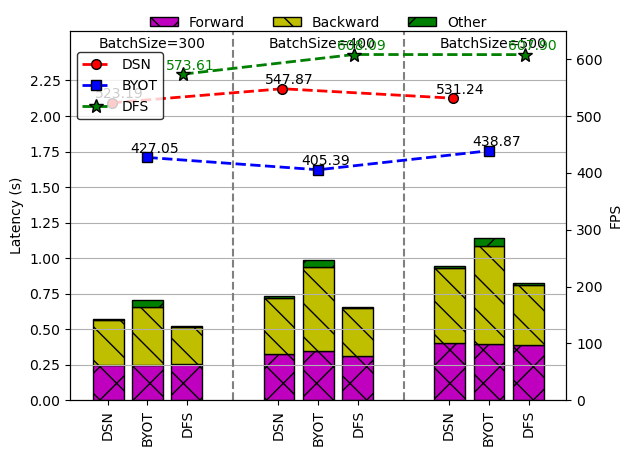

In [16]:
# 画图
import numpy as np
# def process_results_to_abs_cap(results,dns_ratio=0.5):
#        # dsn_results
#        results = [line for line in results if line[0]==dns_ratio]
#        # 必须按照batchsize排序
#        batchsize_id = -1
#        results = sorted(results, key=lambda x:x[batchsize_id])
#        results = np.array(results)
#        res_abs = results[:,1:5].sum(axis=1)
#        res_cap = results[:,1:5]/res_abs.reshape(3,-1)
#        # 最后两列相加
#        res_cap = np.concatenate([res_cap[:,:2],res_cap[:,2:].sum(1).reshape(3,-1)],axis=1)
#        batchsizes = results[:,-1]
#        return batchsizes, res_abs, res_cap
# dsn_results
batchsizes = [300,400,500]
dns_ratio = [0.5]
dsn_res_abs, dsn_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dsn_results,dns_ratio,batchsizes)
dns_res_abs, dns_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dns_results,dns_ratio,batchsizes)
# msdnet_res_abs,msdnet_res_cap = process_results_to_abs_cap_by_ratio_batchsize(msdnet_results,dns_ratio,batchsizes)
byot_res_abs,byot_res_cap = process_results_to_abs_cap_by_ratio_batchsize(byot_results,dns_ratio,batchsizes)

plt.figure()
# dsn_res_cap = [[v[0]/sum(v),v[1]/sum(v),sum(v[2:])/sum(v)] for v in dsn_values]
# dsn_res_abs = [sum(v) for v in dsn_values]
# dns_res_cap = [[v[0]/sum(v),v[1]/sum(v),sum(v[2:])/sum(v)] for v in dns_values]
# dns_res_abs = [sum(v) for v in dns_values]
# dsn_res_abs = [0.39442899492051864, 1.5834714836544461, 2.6547577646043568]
# dsn_res_cap = [[0.3882926250685396, 0.6117073749314604],
#  [0.37996687759823256, 0.6200331224017674],
#  [0.38459201456885905, 0.6154079854311408]]
# batchsizes = [100,300,500]
# colors = ['r', 'g', 'b', 'y', 'm']
colors = ["m",'y','g']
patterns = ['x', '\\','/', 'x', '+', '-']
bw = 18
# plt.bar(batchsizes, dsn_res_abs,width=50)
# 绘制条形图
fig, ax = plt.subplots()

for bindex in range(len(batchsizes)):
       # dsn
       abs_value = dsn_res_abs[bindex]
       dsn_f_time = dsn_res_cap[bindex][0]*abs_value
       dsn_b_time = dsn_res_cap[bindex][1]*abs_value
       dsn_other_time = dsn_res_cap[bindex][2]*abs_value
       dsn_fps = np.array(batchsizes)/np.array(dsn_res_abs)
       print(dsn_f_time,dsn_b_time,dsn_other_time)
       ax.bar(batchsizes[bindex]-1.5*bw-5, dsn_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0,label="Forward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-1.5*bw-5, dsn_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time,label="Backward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-1.5*bw-5, dsn_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time+dsn_b_time,label="Other" if bindex==0 else None)
       # ax.annotate(f"{int(dsn_fps[bindex])}FPS", xy=(batchsizes[bindex]-bw-15, dsn_f_time+dsn_b_time+dsn_other_time+0.1),rotation=90)
       
       # byot
       abs_value = byot_res_abs[bindex]
       byot_f_time = byot_res_cap[bindex][0]*abs_value
       byot_b_time = byot_res_cap[bindex][1]*abs_value
       byot_other_time = byot_res_cap[bindex][2]*abs_value
       byot_fps = np.array(batchsizes)/np.array(byot_res_abs)
       ax.bar(batchsizes[bindex]-0.5*bw, byot_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]-0.5*bw, byot_b_time,
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=byot_f_time)
       ax.bar(batchsizes[bindex]-0.5*bw, byot_other_time,
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=byot_f_time+byot_b_time)
       # ax.annotate(f"{int(byot_fps[bindex])}FPS", xy=(batchsizes[bindex]-6, byot_f_time+byot_b_time+byot_other_time+0.1),rotation=90)
       
       # dns
       abs_value = dns_res_abs[bindex]
       dns_f_time = dns_res_cap[bindex][0]*abs_value
       dns_b_time = dns_res_cap[bindex][1]*abs_value
       dns_other_time = dns_res_cap[bindex][2]*abs_value
       dns_fps = np.array(batchsizes)/np.array(dns_res_abs)
       ax.bar(batchsizes[bindex]+0.5*bw+5, dns_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]+0.5*bw+5, dns_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=dns_f_time)
       ax.bar(batchsizes[bindex]+0.5*bw+5, dns_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=dns_f_time+dns_b_time)
       # ax.annotate(f"{int(dns_fps[bindex])}FPS", xy=(batchsizes[bindex]+bw+2, dns_f_time+dns_b_time+dns_other_time+0.1),rotation=90,color="g")

# plt.xticks(batchsizes, [100,300,500])
ax.annotate(f"BatchSize={int(batchsizes[0])}", xy=(batchsizes[0]-1.6*bw, 2.48))
ax.annotate(f"BatchSize={int(batchsizes[1])}", xy=(batchsizes[1]-1.6*bw, 2.48))
ax.annotate(f"BatchSize={int(batchsizes[2])}", xy=(batchsizes[2]-1.6*bw, 2.48))

x1 = np.array(batchsizes[:2]).mean()
x2 = np.array(batchsizes[1:]).mean()
ax.plot([x1,x1],[0,5],'--',color='gray')
ax.plot([x2,x2],[0,5],'--',color='gray')
plt.xticks([batchsizes[0]-1.3*bw,batchsizes[0],batchsizes[0]+1.3*bw,batchsizes[1]-1.3*bw,batchsizes[1],batchsizes[1]+1.3*bw,
            batchsizes[2]-1.3*bw,batchsizes[2],batchsizes[2]+1.3*bw], ["DSN","BYOT","DFS","DSN","BYOT","DFS","DSN","BYOT","DFS"],rotation=90)
plt.yticks(np.arange(0, 2.5, 0.25),[f"{i:.2f}" for i in np.arange(0, 2.5, 0.25)])
ax.tick_params(axis='x', rotation=90)
# 设置图形标题和坐标轴标签
# plt.title('Training efficiency of VGG on Cifar100 on CPU (Xeon E5-2678 v3)')
ax.set_ylabel('Latency (s)')
ax.set_ylim(0, 2.6)
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.075), ncol=3,facecolor='none', edgecolor='w', frameon=None)
# ax.legend(loc='upper left')
# plt.legend()
plt.grid(axis='y')
# ax.set_xlabel('Batch Size')
# ax.xaxis.set_label_coords(0.5, -0.15)

# 画出FPS
ax2 = ax.twinx()
ax2.plot(np.array(batchsizes)-1*bw-3, dsn_fps, 
         color='r', marker='o', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="DSN")
# 在每个点上标注数据值
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]-1*bw-3
       y = dsn_fps[bindex]
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+8), color='black')

# byot
ax2.plot(np.array(batchsizes), byot_fps,
               color='b', marker='s', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="BYOT")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]
       y = byot_fps[bindex]
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+8), color='black')

ax2.plot(np.array(batchsizes)+bw+3, dns_fps, 
         color='g', marker='*', markeredgecolor='k',linestyle='--', linewidth=2, markersize=10,label="DFS")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]+bw+3
       y = dns_fps[bindex]
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+8), color='g')

ax2.set_ylabel('FPS')
ax2.set_ylim(0, 650)
ax2.legend(loc='upper center',bbox_to_anchor=(0.1, 0.96), ncol=1,facecolor='w', edgecolor='k', frameon=None)

# 显示图形
save_path = f"./"
# plt.savefig(save_path+'/figures/training-efficiency-vgg-on-cifar100-on-CPU.pdf', dpi=300, bbox_inches='tight')
plt.show()

0.2513 0.3146 0.007500000000000001
0.3231 0.3982 0.008799999999999999
0.4052 0.5269 0.0091


<Figure size 640x480 with 0 Axes>

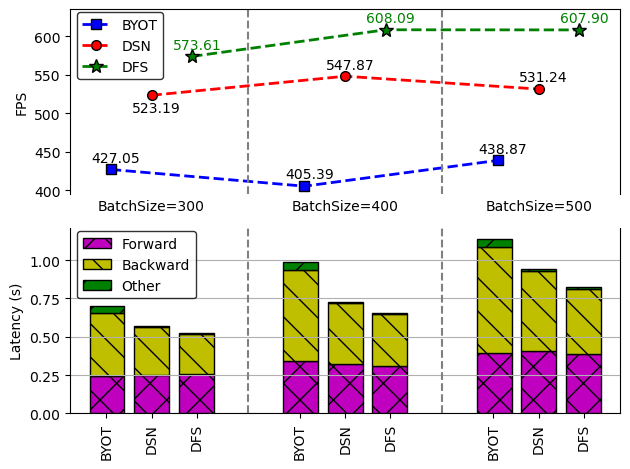

In [17]:
# 画图
import numpy as np
# dsn_results
# batchsizes = [300,400,500]
# dns_ratio = [0.5]
# dsn_res_abs, dsn_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dsn_results,dns_ratio,batchsizes)
# dns_res_abs, dns_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dns_results,dns_ratio,batchsizes)
# msdnet_res_abs,msdnet_res_cap = process_results_to_abs_cap_by_ratio_batchsize(msdnet_results,dns_ratio,batchsizes)
# byot_res_abs,byot_res_cap = process_results_to_abs_cap_by_ratio_batchsize(byot_results,dns_ratio,batchsizes)

plt.figure()
colors = ["m",'y','g']
patterns = ['x', '\\','/', 'x', '+', '-']
bw = 18
# plt.bar(batchsizes, dsn_res_abs,width=50)
# 绘制条形图
# fig, ax = plt.subplots()
fig, (up_ax, ax) = plt.subplots(2,1)

for bindex in range(len(batchsizes)):
       # byot
       abs_value = byot_res_abs[bindex]
       byot_f_time = byot_res_cap[bindex][0]*abs_value
       byot_b_time = byot_res_cap[bindex][1]*abs_value
       byot_other_time = byot_res_cap[bindex][2]*abs_value
       byot_fps = np.array(batchsizes)/np.array(byot_res_abs)
       ax.bar(batchsizes[bindex]-1.5*bw-5, byot_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]-1.5*bw-5, byot_b_time,
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=byot_f_time)
       ax.bar(batchsizes[bindex]-1.5*bw-5, byot_other_time,
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=byot_f_time+byot_b_time)
       # ax.annotate(f"{int(byot_fps[bindex])}FPS", xy=(batchsizes[bindex]-6, byot_f_time+byot_b_time+byot_other_time+0.1),rotation=90)

       # dsn
       abs_value = dsn_res_abs[bindex]
       dsn_f_time = dsn_res_cap[bindex][0]*abs_value
       dsn_b_time = dsn_res_cap[bindex][1]*abs_value
       dsn_other_time = dsn_res_cap[bindex][2]*abs_value
       dsn_fps = np.array(batchsizes)/np.array(dsn_res_abs)
       print(dsn_f_time,dsn_b_time,dsn_other_time)
       ax.bar(batchsizes[bindex]-0.5*bw, dsn_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0,label="Forward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-0.5*bw, dsn_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time,label="Backward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-0.5*bw, dsn_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time+dsn_b_time,label="Other" if bindex==0 else None)
       # ax.annotate(f"{int(dsn_fps[bindex])}FPS", xy=(batchsizes[bindex]-bw-15, dsn_f_time+dsn_b_time+dsn_other_time+0.1),rotation=90)
       
       # dns
       abs_value = dns_res_abs[bindex]
       dns_f_time = dns_res_cap[bindex][0]*abs_value
       dns_b_time = dns_res_cap[bindex][1]*abs_value
       dns_other_time = dns_res_cap[bindex][2]*abs_value
       dns_fps = np.array(batchsizes)/np.array(dns_res_abs)
       ax.bar(batchsizes[bindex]+0.5*bw+5, dns_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]+0.5*bw+5, dns_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=dns_f_time)
       ax.bar(batchsizes[bindex]+0.5*bw+5, dns_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=dns_f_time+dns_b_time)
       # ax.annotate(f"{int(dns_fps[bindex])}FPS", xy=(batchsizes[bindex]+bw+2, dns_f_time+dns_b_time+dns_other_time+0.1),rotation=90,color="g")

# plt.xticks(batchsizes, [100,300,500])
# ax.annotate(f"BatchSize={int(batchsizes[0])}", xy=(batchsizes[0]-1.6*bw, 1.65))
# ax.annotate(f"BatchSize={int(batchsizes[1])}", xy=(batchsizes[1]-1.6*bw, 1.65))
# ax.annotate(f"BatchSize={int(batchsizes[2])}", xy=(batchsizes[2]-1.6*bw, 1.65))

x1 = np.array(batchsizes[:2]).mean()
x2 = np.array(batchsizes[1:]).mean()
ax.plot([x1,x1],[0,5],'--',color='gray')
ax.plot([x2,x2],[0,5],'--',color='gray')
plt.xticks([batchsizes[0]-1.3*bw,batchsizes[0],batchsizes[0]+1.3*bw,batchsizes[1]-1.3*bw,batchsizes[1],batchsizes[1]+1.3*bw,
            batchsizes[2]-1.3*bw,batchsizes[2],batchsizes[2]+1.3*bw], ["BYOT","DSN","DFS","BYOT","DSN","DFS","BYOT","DSN","DFS"],rotation=90)
plt.yticks(np.arange(0, 2.5, 0.25),[f"{i:.2f}" for i in np.arange(0, 2.5, 0.25)])
ax.tick_params(axis='x', rotation=90)
# 设置图形标题和坐标轴标签
# plt.title('Training efficiency of VGG on Cifar100 on CPU (Xeon E5-2678 v3)')
ax.set_ylabel('Latency (s)')
ax.set_ylim(0, 1.21)
ax.set_xlim(batchsizes[0]-1.5*bw-15, batchsizes[2]+1.5*bw+15)
ax.legend(loc='upper left',bbox_to_anchor=(0., 1.02), ncol=1,facecolor='w', edgecolor='k', frameon=None)
# ax.legend(loc='upper left')
# plt.legend()
ax.grid(axis='y')
# ax.set_xlabel('Batch Size')
# ax.xaxis.set_label_coords(0.5, -0.15)
ax.spines['top'].set_visible(False)

# 画出FPS
# ax2 = ax.twinx()
# # byot
up_ax.plot(np.array(batchsizes)-1*bw-3, byot_fps,
               color='b', marker='s', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="BYOT")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]-1*bw-3
       y = byot_fps[bindex]
       up_ax.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+10), color='black')

up_ax.plot(np.array(batchsizes), dsn_fps, 
         color='r', marker='o', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="DSN")
# # 在每个点上标注数据值
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]
       y = dsn_fps[bindex]
       y_bias = -22 if bindex==0 else 10
       up_ax.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+y_bias), color='black')

up_ax.plot(np.array(batchsizes)+bw+3, dns_fps, 
         color='g', marker='*', markeredgecolor='k',linestyle='--', linewidth=2, markersize=10,label="DFS")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]+bw+3
       y = dns_fps[bindex]
       up_ax.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+10), color='g')

x1 = np.array(batchsizes[:2]).mean()
x2 = np.array(batchsizes[1:]).mean()
up_ax.plot([x1,x1],[0,650],'--',color='gray')
up_ax.plot([x2,x2],[0,650],'--',color='gray')
up_ax.set_xlim(batchsizes[0]-1.5*bw-15, batchsizes[2]+1.5*bw+15)
# up_ax.grid(True,axis='x')
# xticks_values = np.concatenate([np.array(batchsizes)-1*bw-3,np.array(batchsizes),np.array(batchsizes)+bw+3])
# up_ax.set_xticks(xticks_values,['']*len(xticks_values))
up_ax.set_xticks([300,400,500],[f"BatchSize={int(b)}" for b in batchsizes])
# 设置x轴和y轴的刻度线不可见
up_ax.tick_params(axis='x', length=0)
# up_ax.set_xticks([])
up_ax.spines['bottom'].set_visible(False)

up_ax.set_ylabel('FPS')
up_ax.set_ylim(395, 635)
up_ax.legend(loc='upper center',bbox_to_anchor=(0.09, 1.02), ncol=1,facecolor='w', edgecolor='k', frameon=None)

# # 显示图形
plt.tight_layout()
save_path = f"./"
# plt.savefig(save_path+'/figures/training-efficiency-vgg-on-cifar100-on-CPU-v4.pdf', dpi=300, bbox_inches='tight')
plt.show()

## VGG16-64 on ImageNet
The data format is list of different methods.

In [18]:
import re
# 获取数据
log_root = "./scripts/logs"
model_name = "vgg16_64_imagenet-mtl"
log_names = [f"vgg16_64_imagenet-mtl-training-efficiency-evaluation-v1-dns_ratio-{i:.1f}-evaluate-training-efficiency.log" for i in [0.1,0.3,0.5,0.7,0.9]]
log_files = [f"{log_root}/{log_name}" for log_name in log_names]

# save to csv files
save_dir = f"./data-src"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
dsn_save_file = f"{save_dir}/{model_name}-training-efficiency-dsn.csv"
dns_save_file = f"{save_dir}/{model_name}-training-efficiency-dns.csv"
msdnet_save_file = f"{save_dir}/{model_name}-training-efficiency-msdnet.csv"
byot_save_file = f"{save_dir}/{model_name}-training-efficiency-byot.csv"

dsn_results = []
dns_results = []
msdnet_results = []
byot_results = []

read_from_log = False

if read_from_log or not os.path.exists(dsn_save_file):
    # 从日志文件中提取数据并存储到csv文件中
    for log_file in log_files:
        _,dsn_res = get_res_from_logfile(log_file,heads, dsn_filters, filter_keys, need_keys,0)
        _,dns_res = get_res_from_logfile(log_file,heads, dns_filters, filter_keys, need_keys,0)
        _,msdnet_res = get_res_from_logfile(log_file,heads, msdnet_filters, filter_keys, need_keys,0)
        _,byot_res = get_res_from_logfile(log_file,heads, byot_filters, filter_keys, need_keys,0)
        dsn_results+=dsn_res
        dns_results+=dns_res
        msdnet_results+=msdnet_res
        byot_results+=byot_res
    # _,res = get_res_from_logfile(log_files[0],heads, dsn_filters, filter_keys, need_keys,0)
    # save to file
    import pandas as pd
    pd.DataFrame(dsn_results, columns=need_keys).to_csv(dsn_save_file, index=False)
    pd.DataFrame(dns_results, columns=need_keys).to_csv(dns_save_file, index=False)
    pd.DataFrame(msdnet_results, columns=need_keys).to_csv(msdnet_save_file, index=False)
    pd.DataFrame(byot_results, columns=need_keys).to_csv(byot_save_file, index=False)
else:
    # 从csv文件中读取数据
    import pandas as pd
    dsn_results = pd.read_csv(dsn_save_file).values.tolist()
    dns_results = pd.read_csv(dns_save_file).values.tolist()
    msdnet_results = pd.read_csv(msdnet_save_file).values.tolist()
    byot_results = pd.read_csv(byot_save_file).values.tolist()

In [19]:
# 画图
import numpy as np
# dsn_results
batchsizes = [128,192,256]
dns_ratio = [0.5]
dsn_res_abs, dsn_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dsn_results,dns_ratio,batchsizes)
dns_res_abs, dns_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dns_results,dns_ratio,batchsizes)
msdnet_res_abs,msdnet_res_cap = process_results_to_abs_cap_by_ratio_batchsize(msdnet_results,dns_ratio,batchsizes)
byot_res_abs,byot_res_cap = process_results_to_abs_cap_by_ratio_batchsize(byot_results,dns_ratio,batchsizes)

0.3498 0.4393 0.0173
0.4633 0.6645 0.027800000000000002
0.5737 0.8905 0.041600000000000005


<Figure size 640x480 with 0 Axes>

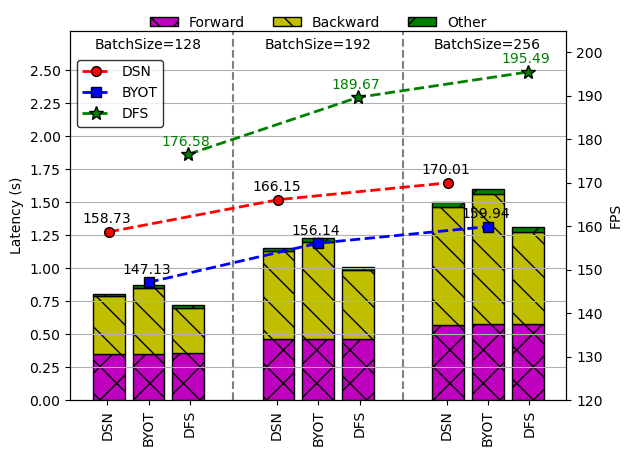

In [20]:
plt.figure()
colors = ["m",'y','g']
patterns = ['x', '\\','/', 'x', '+', '-']
bw = 12
# plt.bar(batchsizes, dsn_res_abs,width=50)
# 绘制条形图
fig, ax = plt.subplots()
# ax2 = ax.twinx()
for bindex in range(len(batchsizes)):
       # dsn
       abs_value = dsn_res_abs[bindex]
       dsn_f_time = dsn_res_cap[bindex][0]*abs_value
       dsn_b_time = dsn_res_cap[bindex][1]*abs_value
       dsn_other_time = dsn_res_cap[bindex][2]*abs_value
       dsn_fps = np.array(batchsizes)/np.array(dsn_res_abs)
       print(dsn_f_time,dsn_b_time,dsn_other_time)
       ax.bar(batchsizes[bindex]-1.5*bw-3, dsn_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0,label="Forward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-1.5*bw-3, dsn_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time,label="Backward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-1.5*bw-3, dsn_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time+dsn_b_time,label="Other" if bindex==0 else None)
       # ax.annotate(f"{int(dsn_fps[bindex])}FPS", xy=(batchsizes[bindex]-bw-5, dsn_f_time+dsn_b_time+dsn_other_time+0.04),rotation=90)
       
       # byot
       abs_value = byot_res_abs[bindex]
       byot_f_time = byot_res_cap[bindex][0]*abs_value
       byot_b_time = byot_res_cap[bindex][1]*abs_value
       byot_other_time = byot_res_cap[bindex][2]*abs_value
       byot_fps = np.array(batchsizes)/np.array(byot_res_abs)
       ax.bar(batchsizes[bindex]-0.5*bw, byot_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]-0.5*bw, byot_b_time,
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=byot_f_time)
       ax.bar(batchsizes[bindex]-0.5*bw, byot_other_time,
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=byot_f_time+byot_b_time)
       # ax.annotate(f"{int(byot_fps[bindex])}FPS", xy=(batchsizes[bindex]-2, byot_f_time+byot_b_time+byot_other_time+0.04),rotation=90)
       
       # dns
       abs_value = dns_res_abs[bindex]
       dns_f_time = dns_res_cap[bindex][0]*abs_value
       dns_b_time = dns_res_cap[bindex][1]*abs_value
       dns_other_time = dns_res_cap[bindex][2]*abs_value
       dns_fps = np.array(batchsizes)/np.array(dns_res_abs)
       ax.bar(batchsizes[bindex]+0.5*bw+3, dns_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]+0.5*bw+3, dns_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=dns_f_time)
       ax.bar(batchsizes[bindex]+0.5*bw+3, dns_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=dns_f_time+dns_b_time)
       # ax.annotate(f"{int(dns_fps[bindex])}FPS", xy=(batchsizes[bindex]+bw+1, dns_f_time+dns_b_time+dns_other_time+0.04),rotation=90,color="g")

# plt.xticks(batchsizes, [100,300,500])
ax.annotate(f"BatchSize={int(batchsizes[0])}", xy=(batchsizes[0]-1.7*bw, 2.66))
ax.annotate(f"BatchSize={int(batchsizes[1])}", xy=(batchsizes[1]-1.7*bw, 2.66))
ax.annotate(f"BatchSize={int(batchsizes[2])}", xy=(batchsizes[2]-1.7*bw, 2.66))

x1 = np.array(batchsizes[:2]).mean()
x2 = np.array(batchsizes[1:]).mean()
ax.plot([x1,x1],[0,5],'--',color='gray')
ax.plot([x2,x2],[0,5],'--',color='gray')
plt.xticks([batchsizes[0]-1.3*bw,batchsizes[0],batchsizes[0]+1.3*bw,batchsizes[1]-1.3*bw,batchsizes[1],batchsizes[1]+1.3*bw,
            batchsizes[2]-1.3*bw,batchsizes[2],batchsizes[2]+1.3*bw], ["DSN","BYOT","DFS","DSN","BYOT","DFS","DSN","BYOT","DFS"],rotation=90)
# plt.xticks(batchsizes,[f"BatchSize={int(i)}" for i in batchsizes])
plt.yticks(np.arange(0, 2.51, 0.25),[f"{i:.2f}" for i in np.arange(0, 2.51, 0.25)])
# ax.tick_params(axis='x', rotation=90)
# 设置图形标题和坐标轴标签
# plt.title('Training efficiency of VGG on Cifar100 on CPU (Xeon E5-2678 v3)')
ax.set_ylabel('Latency (s)')
ax.set_ylim(0, 2.8)
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.075), ncol=3,facecolor='none', edgecolor='w', frameon=None)
# ax.legend(loc='upper left')
# plt.legend()
plt.grid(axis='y')
# ax.set_xlabel('Batch Size')
# ax.xaxis.set_label_coords(0.5, -0.15)

# 画出FPS
ax2 = ax.twinx()
ax2.plot(np.array(batchsizes)-1*bw-3, dsn_fps, 
         color='r', marker='o', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="DSN")
# 在每个点上标注数据值
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]-1*bw-3
       y = dsn_fps[bindex]
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+2), color='black')

# byot
ax2.plot(np.array(batchsizes), byot_fps,
               color='b', marker='s', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="BYOT")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]
       y = byot_fps[bindex]
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+2), color='black')

ax2.plot(np.array(batchsizes)+bw+3, dns_fps, 
         color='g', marker='*', markeredgecolor='k',linestyle='--', linewidth=2, markersize=10,label="DFS")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]+bw+3
       y = dns_fps[bindex]
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+2), color='g')

ax2.set_ylabel('FPS')
ax2.set_ylim(120, 205)
ax2.legend(loc='upper center',bbox_to_anchor=(0.1, 0.94), ncol=1,facecolor='w', edgecolor='k', frameon=None)

# 显示图形
save_path = f"./"
# plt.savefig(save_path+f'/figures/traninig-efficiency-{model_name}-on-GPU.pdf', dpi=300, bbox_inches='tight')
plt.show()

0.3498 0.4393 0.0173
0.4633 0.6645 0.027800000000000002
0.5737 0.8905 0.041600000000000005


<Figure size 640x480 with 0 Axes>

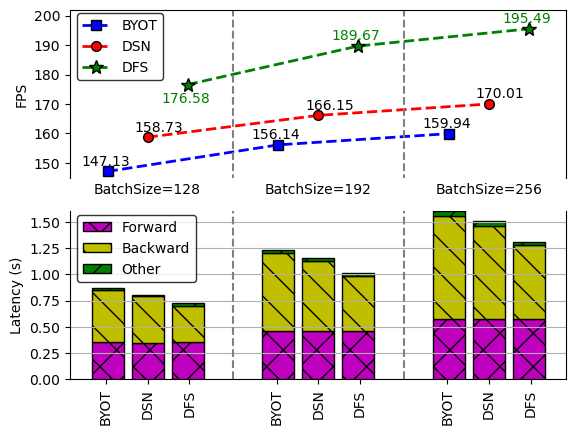

In [21]:
plt.figure()
colors = ["m",'y','g']
patterns = ['x', '\\','/', 'x', '+', '-']
bw = 12
# plt.bar(batchsizes, dsn_res_abs,width=50)
# 绘制条形图
# fig, ax = plt.subplots()
fig, (up_ax, ax) = plt.subplots(2,1)
# ax2 = ax.twinx()
for bindex in range(len(batchsizes)):
       # byot
       abs_value = byot_res_abs[bindex]
       byot_f_time = byot_res_cap[bindex][0]*abs_value
       byot_b_time = byot_res_cap[bindex][1]*abs_value
       byot_other_time = byot_res_cap[bindex][2]*abs_value
       byot_fps = np.array(batchsizes)/np.array(byot_res_abs)
       ax.bar(batchsizes[bindex]-1.5*bw-3, byot_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]-1.5*bw-3, byot_b_time,
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=byot_f_time)
       ax.bar(batchsizes[bindex]-1.5*bw-3, byot_other_time,
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=byot_f_time+byot_b_time)
       # ax.annotate(f"{int(byot_fps[bindex])}FPS", xy=(batchsizes[bindex]-2, byot_f_time+byot_b_time+byot_other_time+0.04),rotation=90)
       
       # dsn
       abs_value = dsn_res_abs[bindex]
       dsn_f_time = dsn_res_cap[bindex][0]*abs_value
       dsn_b_time = dsn_res_cap[bindex][1]*abs_value
       dsn_other_time = dsn_res_cap[bindex][2]*abs_value
       dsn_fps = np.array(batchsizes)/np.array(dsn_res_abs)
       print(dsn_f_time,dsn_b_time,dsn_other_time)
       ax.bar(batchsizes[bindex]-0.5*bw, dsn_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0,label="Forward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-0.5*bw, dsn_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time,label="Backward" if bindex==0 else None)
       ax.bar(batchsizes[bindex]-0.5*bw, dsn_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black',width=bw, align='edge', bottom=dsn_f_time+dsn_b_time,label="Other" if bindex==0 else None)
       # ax.annotate(f"{int(dsn_fps[bindex])}FPS", xy=(batchsizes[bindex]-bw-5, dsn_f_time+dsn_b_time+dsn_other_time+0.04),rotation=90)
       
       
       # dns
       abs_value = dns_res_abs[bindex]
       dns_f_time = dns_res_cap[bindex][0]*abs_value
       dns_b_time = dns_res_cap[bindex][1]*abs_value
       dns_other_time = dns_res_cap[bindex][2]*abs_value
       dns_fps = np.array(batchsizes)/np.array(dns_res_abs)
       ax.bar(batchsizes[bindex]+0.5*bw+3, dns_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0)
       ax.bar(batchsizes[bindex]+0.5*bw+3, dns_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=dns_f_time)
       ax.bar(batchsizes[bindex]+0.5*bw+3, dns_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=dns_f_time+dns_b_time)
       # ax.annotate(f"{int(dns_fps[bindex])}FPS", xy=(batchsizes[bindex]+bw+1, dns_f_time+dns_b_time+dns_other_time+0.04),rotation=90,color="g")

# plt.xticks(batchsizes, [100,300,500])
# ax.annotate(f"BatchSize={int(batchsizes[0])}", xy=(batchsizes[0]-1.7*bw, 2.66))
# ax.annotate(f"BatchSize={int(batchsizes[1])}", xy=(batchsizes[1]-1.7*bw, 2.66))
# ax.annotate(f"BatchSize={int(batchsizes[2])}", xy=(batchsizes[2]-1.7*bw, 2.66))

x1 = np.array(batchsizes[:2]).mean()
x2 = np.array(batchsizes[1:]).mean()
ax.plot([x1,x1],[0,5],'--',color='gray')
ax.plot([x2,x2],[0,5],'--',color='gray')
plt.xticks([batchsizes[0]-1.3*bw,batchsizes[0],batchsizes[0]+1.3*bw,batchsizes[1]-1.3*bw,batchsizes[1],batchsizes[1]+1.3*bw,
            batchsizes[2]-1.3*bw,batchsizes[2],batchsizes[2]+1.3*bw], ["BYOT","DSN","DFS","BYOT","DSN","DFS","BYOT","DSN","DFS"],rotation=90)
# plt.xticks(batchsizes,[f"BatchSize={int(i)}" for i in batchsizes])
plt.yticks(np.arange(0, 2.51, 0.25),[f"{i:.2f}" for i in np.arange(0, 2.51, 0.25)])
# ax.tick_params(axis='x', rotation=90)
# 设置图形标题和坐标轴标签
# plt.title('Training efficiency of VGG on Cifar100 on CPU (Xeon E5-2678 v3)')
ax.set_ylabel('Latency (s)')
ax.set_ylim(0, 1.6)
ax.set_xlim(batchsizes[0]-1.5*bw-11, batchsizes[2]+1.5*bw+11)
ax.legend(loc='upper left',bbox_to_anchor=(0, 1.02), ncol=1,facecolor='w', edgecolor='k', frameon=None)
# ax.legend(loc='upper left')
# plt.legend()
plt.grid(axis='y')
# ax.set_xlabel('Batch Size')
# ax.xaxis.set_label_coords(0.5, -0.15)
ax.spines['top'].set_visible(False)

# 画出FPS
# ax2 = ax.twinx()
# byot
up_ax.plot(np.array(batchsizes)-1*bw-3, byot_fps,
               color='b', marker='s', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="BYOT")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]-1*bw-3
       y = byot_fps[bindex]
       up_ax.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+2), color='black')

up_ax.plot(np.array(batchsizes), dsn_fps, 
         color='r', marker='o', markeredgecolor='k',linestyle='--', linewidth=2, markersize=7,label="DSN")
# 在每个点上标注数据值
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]
       y = dsn_fps[bindex]
       up_ax.annotate('%.2f' % y, xy=(x, y), xytext=(x-5, y+2), color='black')


up_ax.plot(np.array(batchsizes)+bw+3, dns_fps, 
         color='g', marker='*', markeredgecolor='k',linestyle='--', linewidth=2, markersize=10,label="DFS")
for bindex in range(len(batchsizes)):
       x = batchsizes[bindex]+bw+3
       y = dns_fps[bindex]
       ybias = 2 if bindex>0 else -6
       up_ax.annotate('%.2f' % y, xy=(x, y), xytext=(x-10, y+ybias), color='g')

x1 = np.array(batchsizes[:2]).mean()
x2 = np.array(batchsizes[1:]).mean()
up_ax.plot([x1,x1],[0,650],'--',color='gray')
up_ax.plot([x2,x2],[0,650],'--',color='gray')
up_ax.set_xlim(batchsizes[0]-1.5*bw-11, batchsizes[2]+1.5*bw+11)
up_ax.set_xticks(batchsizes,[f"BatchSize={int(b)}" for b in batchsizes])
# 设置x轴和y轴的刻度线不可见
up_ax.tick_params(axis='x', length=0)
# up_ax.set_xticks([])
up_ax.spines['bottom'].set_visible(False)

up_ax.set_ylabel('FPS')
up_ax.set_ylim(145, 202)
up_ax.legend(loc='upper center',bbox_to_anchor=(0.1, 1.02), ncol=1,facecolor='w', edgecolor='k', frameon=None)

# # 显示图形
save_path = f"./"
# plt.savefig(save_path+f'/figures/traninig-efficiency-{model_name}-on-GPU-v3.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Coefficient selection will affect the training efficiency
## 结论:
我们在理论推导中证明了,不同的系数可以实现相同的反向传播的计算量降低.但是实验结果表明,不不同的系数会影响到训练效率,总结而言,系数为0.5时,其训练效率最高,因为其前向和反向传播的延时相比于其他系数的都更低,训练的FPS最高.这主要是由于计算依赖和计算负载不均衡导致的.
反向传播必须先深层梯度然后计算浅层梯度,因此其存在计算依赖,更复杂的深层操作将影响反向传播延时.
在多任务学习中,反向传播必须同时计算浅层和深层任务对权值和特征的梯度,两者之间可能存在计算负载不均衡和等待同步的问题.
在DNS中,大的系数值将为多任务分配更多共享特征深层,这将导致更复杂的深层梯度计算.
反之,更低的系数值将降低深层任务的训练参数,但是增加浅层任务的训练参数,这将导致多任务间的计算负载不均衡从而影响效率.

In [22]:
save_dir = f"./data-src"
# model_name = 'vgg16_64_imagenet-mtl'
model_name = "vgg7_64_cifar100-mtl"
dns_save_file = f"{save_dir}/{model_name}-training-efficiency-dns-v4.csv"

dns_results = pd.read_csv(dns_save_file).values.tolist()

In [23]:
dns_ratios=[0.1,0.3,0.5,0.7,0.9]
# batchsizes=[100,200,300,400,500,750,1000]
batchsizes = [500]
dns_res_abs, dns_res_cap = process_results_to_abs_cap_by_ratio_batchsize(dns_results,dns_ratios,batchsizes)
dns_res_abs, dns_res_cap,[line for line in dns_results if line[0] in dns_ratios and line[-1] in batchsizes]

(array([0.8573, 0.8527, 0.8225, 0.8506, 0.8709]),
 array([[0.47952875, 0.5092733 , 0.01119795],
        [0.47824557, 0.51143427, 0.01032016],
        [0.47221884, 0.51744681, 0.01033435],
        [0.46978603, 0.51845756, 0.01175641],
        [0.45183144, 0.53737513, 0.01079343]]),
 [[0.1, 0.4111, 0.4366, 0.0031, 0.0065, 0.8572, 583.2824, 500.0],
  [0.3, 0.4078, 0.4361, 0.0029, 0.0059, 0.8527, 586.3916, 500.0],
  [0.5, 0.3884, 0.4256, 0.0031, 0.0054, 0.8225, 607.8785, 500.0],
  [0.7, 0.3996, 0.441, 0.003, 0.007, 0.8506, 587.8417, 500.0],
  [0.9, 0.3935, 0.468, 0.003, 0.0064, 0.8708, 574.1632, 500.0]])

<Figure size 640x480 with 0 Axes>

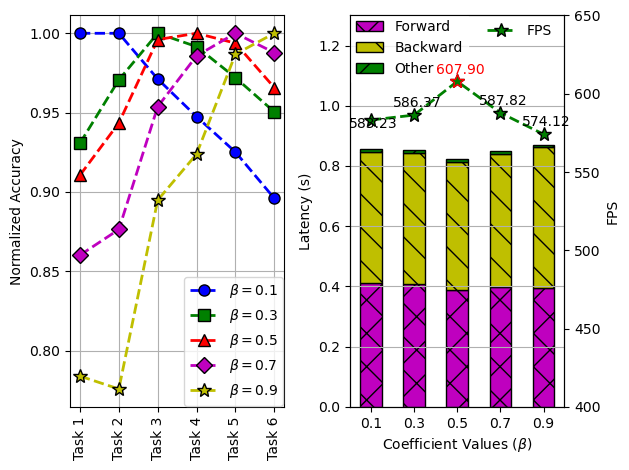

In [24]:
# dns_res_abs,dns_res_cap
# 画图应该画出前向和反向传播的实践比例,以及对应的FPS结果,类似上图,
plt.figure()
# plt.bar(batchsizes, dsn_res_abs,width=50)
fig, (left_ax, ax) = plt.subplots(1,2)
# Fack accuracy
accuracy_across_ratio = np.array([[22.81, 41.56, 53.93, 58.58, 63.87, 65.46],
                         [21.23, 40.34, 55.53, 61.31, 67.11, 69.44],
                         [20.77, 39.21, 55.31, 61.83, 68.61, 70.56],
                         [19.62, 36.42, 52.96, 60.95, 69.04, 72.17],
                         [17.88, 32.24, 49.69, 57.12, 68.13, 73.06]])
normalized_accuracy_across_ratio=accuracy_across_ratio/accuracy_across_ratio.max(0)
colors = ["b","g","r","m",'y','c','k']
markers = ["o","s","^","D","*","+","x"]
patterns = ['x', '\\','/', 'x', '+', '-']
linestyles = ['--','--','--','--','--','--']
markersizes = [8,8,8,8,10]

for i, ratio in enumerate(dns_ratios):
    left_ax.plot(np.arange(1,7,1),normalized_accuracy_across_ratio[i],color=colors[i], marker=markers[i], markeredgecolor='black',
                 linestyle=linestyles[i], linewidth=2, alpha=1,
                 markersize=markersizes[i],label=r"$\beta=%.1f$"%(ratio))

left_ax.set_xticks(np.arange(1,7,1),[f"Task {i}" for i in np.arange(1,7,1)],rotation=90)
left_ax.set_ylabel("Normalized Accuracy")
left_ax.grid()
# left_ax.set_ylim(16,75)
# plt.show()

colors = ["m",'y','g']
patterns = ['x', '\\','/', 'x', '+', '-']
bw = 0.1
ax2 = ax.twinx()
dns_fps = np.array(batchsizes)/np.array(dns_res_abs)

ax2.plot(dns_ratios, dns_fps, 
         color='g', marker='*', markeredgecolor='black',linestyle='--', linewidth=2, markersize=10,label="FPS")
ax2.plot([0.5],dns_fps[2],color='g', marker='*', markeredgecolor='red',linestyle='', markersize=10)
for dns_ratio in range(len(dns_ratios)):
       x = dns_ratios[dns_ratio]
       y = dns_fps[dns_ratio]
       if y>=max(dns_fps):
             color = 'r'
       else:
             color = 'k'
       if dns_ratio<0.5:
             y_bias = -5
       else:
             y_bias = 5
       ax2.annotate('%.2f' % y, xy=(x, y), xytext=(x-0.1, y+y_bias), color=color)

ax2.set_ylim(400,650)
ax2.set_ylabel(r"FPS")
ax.set_ylabel("Latency (s)")
ax.set_ylim(0,1.3)
for dns_ratio in range(len(dns_ratios)):
       abs_value = dns_res_abs[dns_ratio]
       dns_f_time = dns_res_cap[dns_ratio][0]*abs_value
       dns_b_time = dns_res_cap[dns_ratio][1]*abs_value
       dns_other_time = dns_res_cap[bindex][2]*abs_value
       ax.bar(dns_ratios[dns_ratio]-0.05, dns_f_time, 
              color=colors[0],hatch=patterns[0], edgecolor='black', width=bw, align='edge', bottom=0,label="Forward" if dns_ratio==0 else None)
       ax.bar(dns_ratios[dns_ratio]-0.05, dns_b_time, 
              color=colors[1],hatch=patterns[1], edgecolor='black', width=bw, align='edge', bottom=dns_f_time,label="Backward" if dns_ratio==0 else None)
       ax.bar(dns_ratios[dns_ratio]-0.05, dns_other_time, 
              color=colors[2],hatch=patterns[2], edgecolor='black', width=bw, align='edge', bottom=dns_f_time+dns_b_time,label="Other" if dns_ratio==0 else None)
ax.grid(axis='y')
left_ax.legend(loc="upper left",ncol=1,bbox_to_anchor=(0.5, 0.35), facecolor='w', edgecolor=None, frameon=None)
ax.legend(loc="upper center",ncol=1,bbox_to_anchor=(0.275, 1.02), facecolor='w', edgecolor='w', frameon=None)
ax2.legend(loc="upper right",ncol=1,bbox_to_anchor=(1., 1.01), facecolor='w', edgecolor='w', frameon=None)

plt.xticks(dns_ratios,dns_ratios)
# plt.xlabel("Coefficient Values")
ax.set_xlabel(r'Coefficient Values ($\beta$)')
# ax.xaxis.set_label_coords(0.5, -0.15)
plt.tight_layout()
save_path = f"./"
# plt.savefig(save_path+f'/figures/coefficient-selection-for-{model_name}-on-accuracy-training-efficiency-v3.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Adaptive Inference Experiments

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
root = f"./"
save_file = root+"data-src/flops-vs-acc.csv"
flops_acc = pd.read_csv(save_file).values[1:,:].astype(float)


In [26]:
MSDNet_res = flops_acc[:,:2].T # 前两列
GE_res = flops_acc[:,2:4].T # 前2-4列
MateGF_res = flops_acc[:,4:6].T # 前4-6列
DFS_res = flops_acc[:,6:8].T # 前6-8列
# pd.read_csv(save_file).values[1:,:].astype(float)

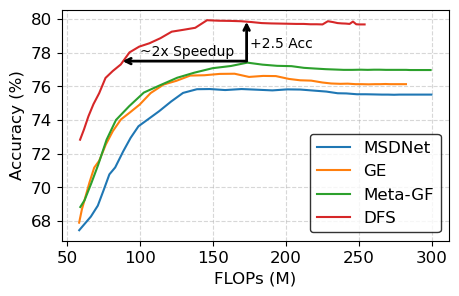

In [27]:
names = ["MSDNet","GE","Meta-GF","DFS"]

cmap = plt.get_cmap('rainbow')
fs = 12

# colors = [cmap(i) for i in np.linspace(0, 1, len(names))]
colors = [None]*len(names)

plt.figure(figsize=(5,3))
plt.plot(MSDNet_res[0],MSDNet_res[1],label="MSDNet",color = colors[0], 
         marker='o',linestyle='-',linewidth=1.5,markersize=0)
plt.plot(GE_res[0],GE_res[1],label="GE",color = colors[1],
         marker='s',linestyle='-',linewidth=1.5,markersize=0)
plt.plot(MateGF_res[0],MateGF_res[1],label="Meta-GF",color = colors[2],
         marker='^',linestyle='-',linewidth=1.5,markersize=0)
plt.plot(DFS_res[0],DFS_res[1],label="DFS",color = colors[3],
         marker='d',linestyle='-',linewidth=1.5,markersize=0)

# 使用annotate函数画出带箭头的直线
plt.annotate('', xy=(86, 77.5), xytext=(175, 77.5),
             arrowprops=dict(arrowstyle='->', linewidth=2, color='k'))
plt.annotate("~2x Speedup", xy=(100, 77.8),color='k')


plt.annotate('', xy=(173, 80), xytext=(173, 77.4),
             arrowprops=dict(arrowstyle='->', linewidth=2, color='k'))
plt.annotate("+2.5 Acc", xy=(175, 78.3),color='k')

plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel("FLOPs (M)",fontsize=fs)
plt.ylabel("Accuracy (%)",fontsize=fs)
plt.legend(fontsize=fs,facecolor='w', edgecolor='k', frameon=None)
plt.grid(linestyle='--',alpha=0.5)

save_dir = f"./figures"
# plt.savefig(f"{save_dir}/flops-vs-acc.pdf", dpi=300, bbox_inches='tight',pad_inches=0.0)
plt.show()